В данном ноутбуке был проведен разведывательный анализ имеющихся данных. Чтобы оптимизировать размер ноутбука, при выгрузке в GitHub используются статические изображения, но при воспроизведении и изучении крайне рекомендуется пользоваться нативными интерактивными визуализациями `plotly`, так как некоторые тикеры спрятаны в выпдающие меню, а, с другой стороны, во всплывающих при наведении окнах часто можно увидеть очень полезные инсайты.

### Импорты

In [23]:
import pandas as pd
# Monkey patch for pandas_ta
import numpy as np
np.NaN = np.nan

In [24]:
import os
import sys

repo_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.insert(0, repo_root)

from src.data.loaders.data_loader import DataLoader
from src.config.schemas.data import DataLoaderConfig, DatasetSchema
from src.config.schemas.features import ReturnsMethod, FeatureConfig, ReturnsConfig
from src.data.processors.winsorization import winsorize
from src.features.calculators.returns import calculate_returns
from src.features.feature_builder import FeatureBuilder
from src.data.splitters.cross_validation import GroupTimeSeriesSplit
from src.utils.visualization import plot_price, plot_returns, plot_correlation_matrix, plot_distbox

### Загрузка данных и краткий экскурс

In [25]:
mapping = DatasetSchema(timestamps="timestamp")
config = DataLoaderConfig(mapping=mapping, read_options={"sep": ";"})
loader = DataLoader(config)

In [26]:
dfs = loader.load("/home/denisalpino/dev/stock_prediction/data/crypto/15min/raw")

In [27]:
print(f"Total cryptos: {len(dfs)}")
for df in dfs:
    print(f"Ticker: {df.ticker.iloc[0]}. {df.shape[0]} rows")

Total cryptos: 8
Ticker: JASMY. 34951 rows
Ticker: BTC. 34951 rows
Ticker: ETH. 34951 rows
Ticker: LINK. 34951 rows
Ticker: AAVE. 34951 rows
Ticker: BNB. 34951 rows
Ticker: OP. 34951 rows
Ticker: LDO. 34951 rows


In [28]:
dfs[0].describe()

,open,high,low,close
count,34951.000000,34951.000000,34951.000000,34951.000000
mean,0.004754,0.004771,0.004736,0.004754
std,0.001157,0.001165,0.001149,0.001157
min,0.002867,0.002924,0.002837,0.002878
25%,0.003765,0.003774,0.003755,0.003765
50%,0.004642,0.004656,0.004630,0.004642
75%,0.005527,0.005552,0.005503,0.005527
max,0.008268,0.008364,0.008200,0.008268


In [29]:
dfs_merged = pd.concat(dfs, ignore_index=True)

### Сырые стоимости

In [ ]:
plot_price(
    dfs_merged,
    display_mode="subplots",
    chart_type="line",
    subplots_grid=(4, 2),
    width=1800, height=1000,
    theme="dark",
    title="Closing prices of 8 cryptocurrencies paired with USDT"
)

Исходя из графиков видно каноническое свойство финансовых данных — **нестационарность**. Это ожидаемо и неинтересно. В данном эксперименте мы планируем применять алгоритм градиентного бустинга для краткосрочного прогнозирования стоимости (регрессия) и предсказания направления движения (бинарная классификация). С практической точки зрения, для задачи регрессии на XGBoost, нас интересуют макисмумы и минимумы. Это связано с тем, что **деревянные модели не могут экстраполировать** данные с обучающей выборки, такие алгоритмы заточены исключительно на предсказания посредством интерполяции ранее увиденных значений в силу специфики алгоритма.

На графике мы видим следующее:
- для большинства монет (OP, AAVE, LINK, ETH и BTC) в конце периода происходит выход за локальный максимум в датасете. Это означает, что мы **не можем воспользоваться `train_test_split()`**, забрав на валидацию и тест суммарно 10-20% данных с конца, так как деревянные регрессоры не смогут экстраполировать максимум.
- для ряда активов (JASMY, BNB, AAVE и LINK) мы можем наблюдать обновление минимумов в различные моменты времени в середине периода, что **исключает использование кросс-валидации на таргете в виде сырой стоимости**, так как в некоторых фолдах обязательно будут значения вне исторических диапазон, которые деревянный регрессор не сможет предсказывать.

Важно учесть тот факт, что мы **предпочитаем использовать кросс-валидацию** для оптимизации гиперпараметров и справдливой оценки качества построенной модели. Учитывая, что базовые экспиременты будут проводиться на деревянных моделях, для нас **важно, чтобы целевая переменная имела приблизительно нормальное распределение** и **как можно меньше экстримальных значений**.

Здесь есть несколько подходов:
1. Работать с доходностями (абсолютными, процентными, логарифмированными) и применять дополнительные техники для стационаризации и приведения к нормальной форме (например, винсоризация и масштабирование).
2. Попробовать привести ряд к стационарному виду при помощи статистических методов. Например, найти тренд и сезонность при помощи метода Вилкса, FFT или ACF, провести STL-декомпозицю и дальше отталкиваться от полученных резульатов.

Мы прибегнем к первому варианту и далее попробуем привести ряд к более пригодному для прогнозирования виду.

#### Сырые доходности

In [31]:
dfs_merged['returns'] = pd.concat(
    [calculate_returns(df.close, ReturnsMethod.PERCENT) for df in dfs],
    axis=0,
    ignore_index=True
)
dfs_viz = dfs_merged.dropna()

In [ ]:
plot_returns(
    dfs_viz,
    display_mode="subplots",
    subplots_grid=(4, 2),
    width=1800, height=900,
    theme="dark",
    title="Close-to-close returns of 8 cryptocurrencies paired with USDT (raw)"
)

На графиках присутствуют выборасы, которые относятся:
- к рынку в целом (например, 10 июня, 17 августа, 9 ноября и 11 декабря);
- к конкретным активам (например, 5 февраля для JASMY, 16 октября для BTC).

Тем не менее, некоторые общие рыночные аномалии отражаются не на всех активах. В целом, таких аномалий достаточно, и, как уже было сказано, деревянные регрессоры такое не очень любят. Такие аномалии прежде всего не могут бвть спрогнозированы, но и, более того, они вносят шум в модель. Поэтому от них стоит избавиться.

Самым простым способом считается удаление выбросов, одна в случае с временными рядами это крайне нежелательно, так как сломается последовательность в данных. Поэтому мы прибегнем к винсоризации, то есть клиппингу значений превышающих 99.9 процентиль по тому самому процентилю, а затем посмотрим, что выйдет.

#### Винсоризованные доходности

In [33]:
rets = []

for df in dfs:
    ret = calculate_returns(df.close, ReturnsMethod.PERCENT)
    _, _, ret, = winsorize(ret, ret, ret, winsorize_percent=99.9)
    rets.append(ret)

rets = pd.concat(rets, axis=0, ignore_index=True)

dfs_merged['returns'] = rets
dfs_viz = dfs_merged.dropna()

In [ ]:
plot_returns(
    dfs_viz,
    display_mode="subplots",
    subplots_grid=(4, 2),
    width=1800, height=900,
    theme="dark",
    title="Close-to-close returns of 8 cryptocurrencies paired with USDT (winsorized by 99.9 procentile)"
)

Как видим, доходности стали выглядеть гораздо более аккуратно. У винсоризации есть несколько преимуществ:
- мы не ломаем данные, вырывая из последовательности инстансы;
- мы уменьшаем энтропию данных;
- все это достигается без потери какой-либо значимой информации, так как обрезанные максимумы, все еще остаются максимумами, просто выровненными.

#### Распределение доходностей

In [ ]:
plot_distbox(
    dfs_merged,
    theme='dark',
    bins=100,
    width=1800, height=1600,
    subplots_grid=(4, 2)
)

Анализируя графики, видно, что **наименее подверженными выбросам активами являются LINK и JASMY**, что следует из наименьшего момента 4-го порядка (куртозиса).

Рассматривая волатильность, **ETH, BNB и BTC являются наиболее стабильными** в плане вариативности доходности.

ETH, BTC и BNB, несмотря на то, что обладают гораздо большей капитализацией и по идее должны быть менее подвижными, следовательно и аномальными, наоборот, **демонстрируют наибольшее количество выбросов** (более тяжелые хвосты).

Также можно наблюдать **небольшой забор** у AAVE и BNB, скорее всего, это связано с минимальным шагом стоимости, поэтому можно не обращать на это внимание.

Исходя из этих наблюдений, можно получить инсайт, что если бы мы использовали бэггинг, то лучше всего он показывал себя на LINK и JASMY, а хуже - на ETH, BNB и BTC. С другой стороны, неизвестно как этот факт скажется на градиентном бустинге.

In [36]:
featue_cfg = FeatureConfig(
    returns=ReturnsConfig(method=ReturnsMethod.PERCENT)
)
feature_builder = FeatureBuilder(featue_cfg)

In [37]:
returns = [df.copy() for df in dfs]

for df in returns:
    df["timestamps"] = pd.to_datetime(df.timestamps)
    ret = calculate_returns(df.close, ReturnsMethod.PERCENT)
    _, _, ret, = winsorize(ret, ret, ret, winsorize_percent=99.9)
    df["target"] = ret.shift(-1)

In [38]:
dfs_featured = [feature_builder.build_features(df) for df in returns]

In [39]:
dfs_full = [pd.concat([df, feat], axis=1) for df, feat in zip(returns, dfs_featured)]

### Корреляционный анализ

Корреляционный анализ существенно, очень просто и понятно помогает ототбрать наиболее перспективные признаки. Основной принцип при отборе для хорошей фичи таков:
- фича должна как можно СИЛЬНЕЕ коррелировать с таргетом;
- фича должна как можно СЛАБЕЕ коррелировать с отстальными фичами.

Этот приницп обуславливается просто здравой логикой о мультиколлиниарности, которая, в целом, в этом кейсе не так важна, и проклятием размерности, что действительно значимо с точки зрения практики. Если у нас будет много коррелированных фичей, тогда модель будет распыляться на уже выученные закономерности, которые заложены в коррелированную переменную, а наше гиперпространство будет расти, поэтом модель будет недообучаться.

Для рассчета корреляции возьмем метод Спирмена по причине большей ниверсальности - данный метод позволяюет учитывать нелинейные взаимосвязи, при этом почти не имея трейд-оффа по детекции линейных взаимосвязей, значительно отствавя от метода Пирсона лишь в некоторых редких случаях.

/home/denisalpino/dev/stock_prediction/src/utils/visualization/plot_correlation_matrix.py:36: UserWarning:

Categorical variables detected: ['ticker']. Encoding with LabelEncoder.



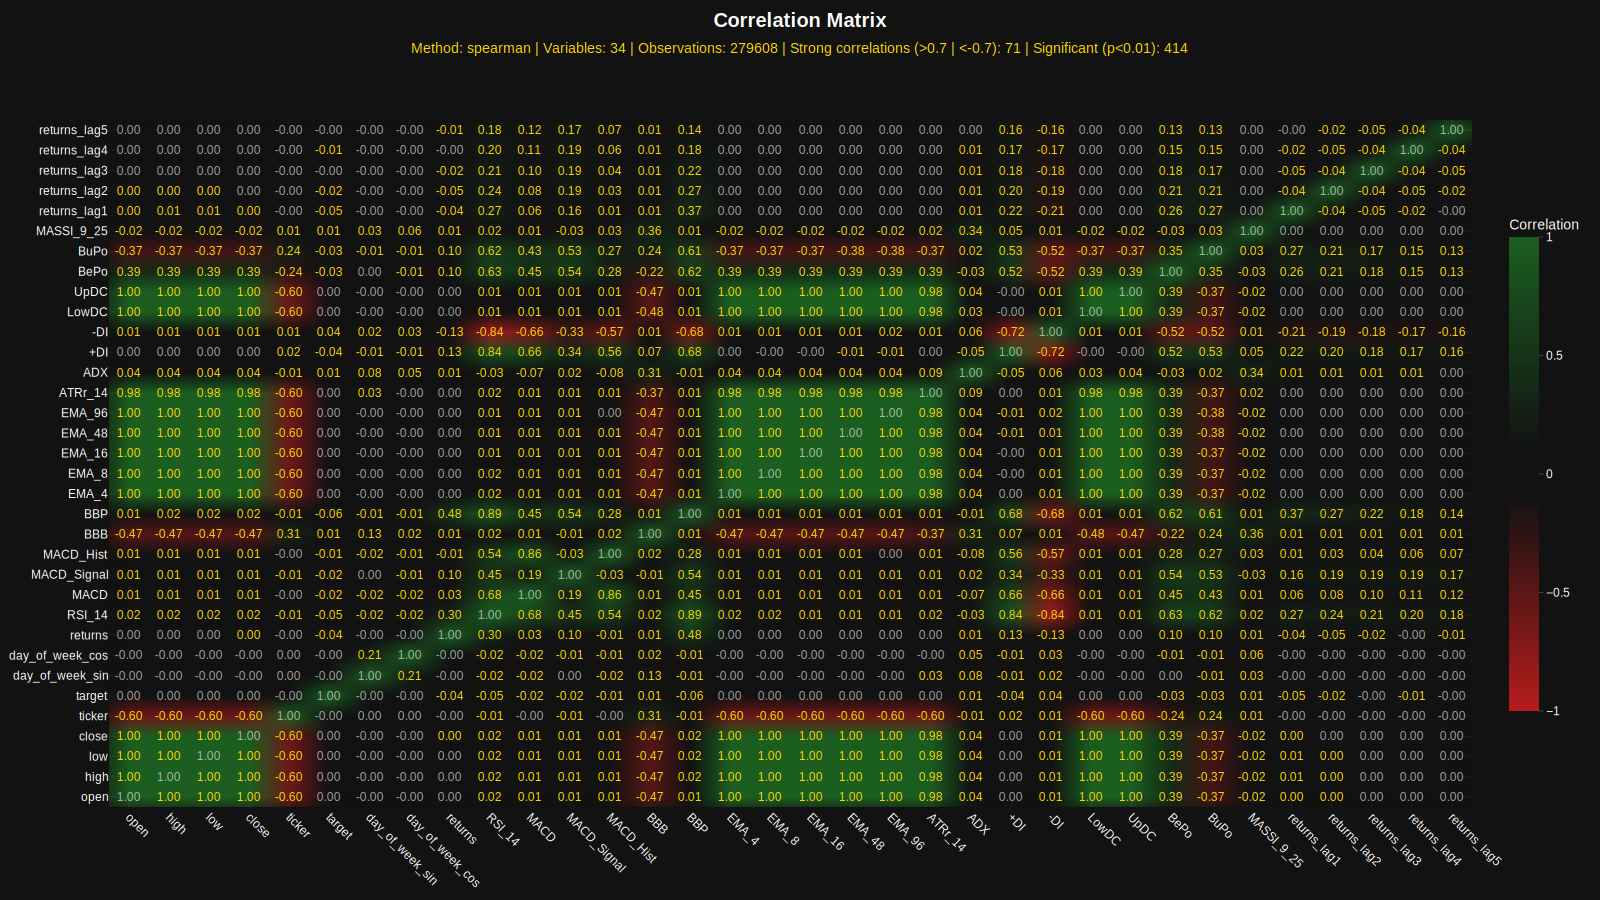

In [45]:
plot_correlation_matrix(
    pd.concat(dfs_full, axis=0, ignore_index=True),
    method="spearman",
    mask_upper=False,
    width=1800,
    height=1600,
).show(renderer="svg", width=1600, height=900)

Исходя из построенной матрицы видим, что у нас довольно много базовых признаков, которые сильно коррелируют друг с другом и почти никак не коррелируют с таргетом. В этом плане стоит обратить внимание на различные `EMA`, `OHLC`, `каналы Дончейна`, а также `гистограму MACD`.

Фактически, `MACD_Hist` очень хорошо описывается базовым `MACD` (0.86), поэтому без проблем откинем ее. С другой стороны, `OHLC` и `EMA`, как и `DC` нам не нужны по причине того, что мы перешли от прогнозирования сыврой стоимости к прогнозу возвратов. Каналы Дончейна в этом плане не безнадежны, можно было бы взять разницу с текущей стоимостью или придумать более интересную производную фичу, но мы сейчас работаем с индикаторами в более базовом виде, поэтому опустим `DC`.

Также стоит обратить внимание на доходности, а именно ее лаги. Некоторые из лагов имеют относительно сильную корреляцию с таргетом, причем обратную, что логично. Третий и пятый лаги не имеют стат. значимой значимой корреляции. Фактически, это может быть частично обосновано тем, что мы считаем корреляцию по всем активам вместе. На каждом отдельном активе корреляция может пристствовать. Тем не менее, даже так, в этом нет ничего удивительного, ведь нашей целью на предыдущем шаге было добиться стационарности ряда, вот мы и избавились почти полностью от автокорреляции.

In [41]:
drop_columns = [
    "open", "high", "low", "close",
    "EMA_4", "EMA_8", "EMA_16", "EMA_48", "EMA_96",
    "UpDC", "LowDC",
    "MACD_Hist",
    #"-DI" # Opposite of +DI
]

dfs_effective = [
    df.drop(columns=drop_columns)
    for df in dfs_full
]

/home/denisalpino/dev/stock_prediction/src/utils/visualization/plot_correlation_matrix.py:36: UserWarning:

Categorical variables detected: ['ticker']. Encoding with LabelEncoder.



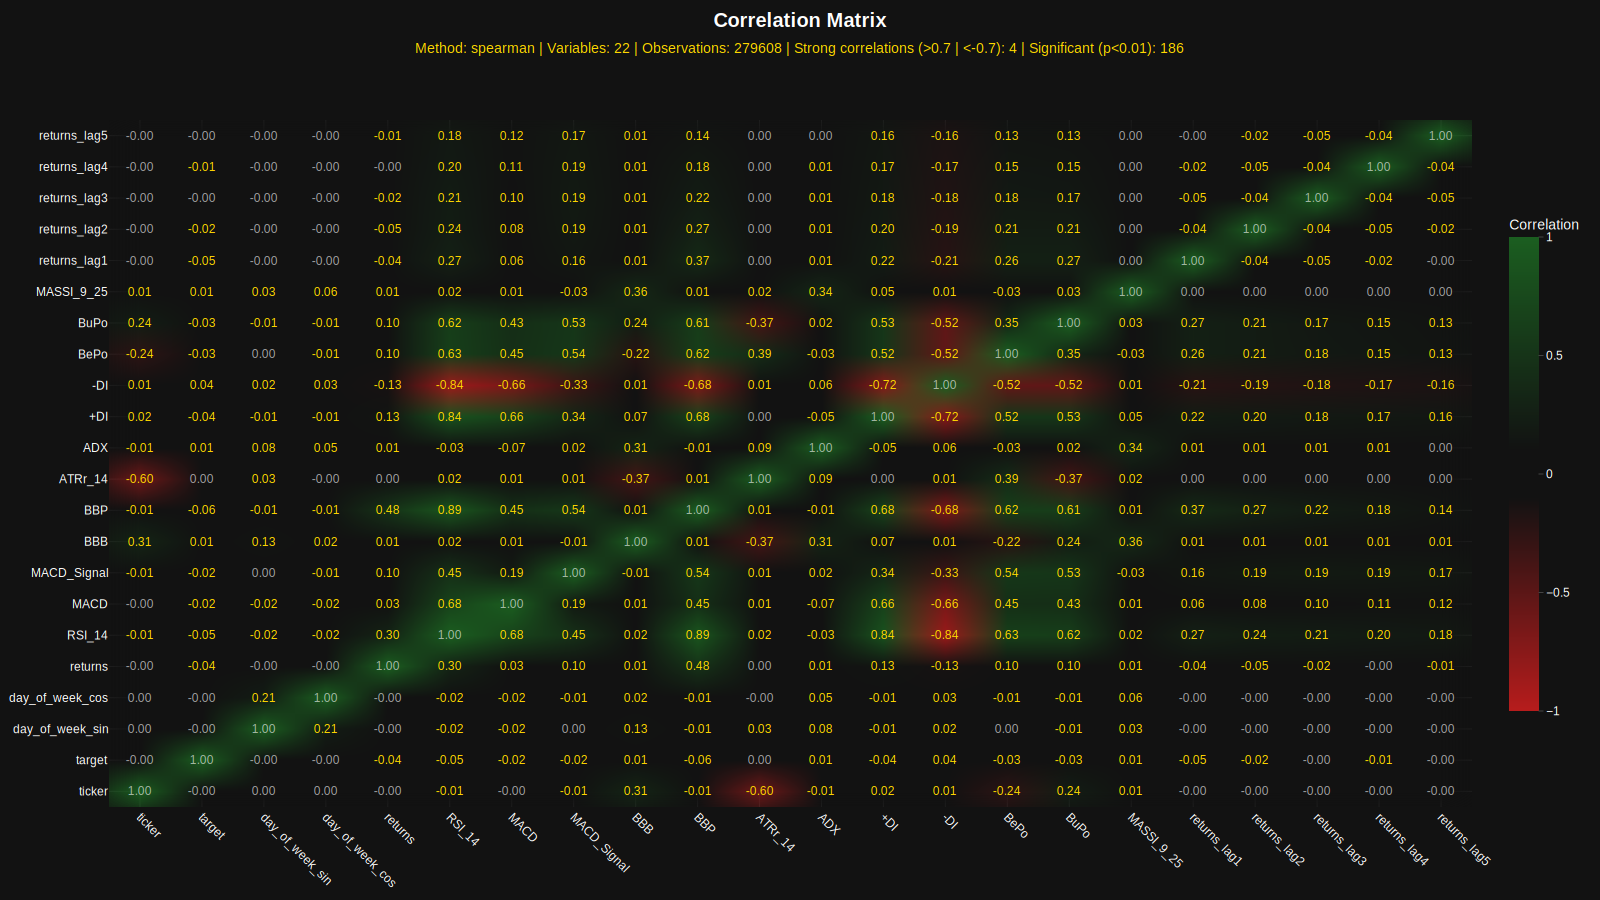

In [46]:
plot_correlation_matrix(
    pd.concat(dfs_effective, axis=0, ignore_index=True),
    method="spearman",
    mask_upper=False,
    width=1800,
    height=1600,
).show(renderer="svg", width=1600, height=900)

Теперь картина стала гораздо лучше, тем не менее, мы видим, что у нас сохранилось 4 высоко коррелированные пары:
- -DI и RSI;
- +DI и RSI;
- BBP и RSI;
- +DI и -DI.

По идее, надо бы убрать RSI и +DI или -DI, однако RSI довольно хороший популярный индикатор, даже небольшая часть непересекающейся корреляции с таргетом может нести высокую значимость. То же, но немного в меньшей степени можно сказать и про обратню пару +DI и -DI. Более того, для последних двух видно, что они по-разному коррелируют с таргетом, как по направлению, так и по пропорции, поэтому решать о значимости стоит уже в ходе анализа полученной модели (например, по gain-информативности или shap-значимости).

Насчет временных фичей тоже неоднозначная ситуация, вроде они и не коррелирую значимо с таргетом, но имеют, хоть и слабые, но значчимые корреляции с другими фичами, соответственно, модель (а в особенности деревяшка) может найти неплохой условный сплит по временной фиче.

Вердикт - оставляем все как есть

### Кросс-валидация

Теперь давайте попробуем подобрать оптимальный сплит на фолды и посмотреть на него.

Мы будем исходить из предположения, что наша модель обучается раз в неделю (хотя для HFT это скорее раз в день, но у нас не очень много ресурсов).

С другой стороны, мы не очень хотим знать всю предыдущую историю, потому что это сильно увеличивает продолжительность обучения и довольно мало значимо на intraday таймфреймах, поэтому будем использовать rolling window с периодом обучения в 4 месяца, чтобы охватить транзитивные периода перехода рынка из одного режима в другой.

Изучив данные визуально, эмпирически был подобран padding в полтора месяца. Такой паддинг в сочетании с пятью фолдами обеспечивает охват как периодов с низкой волатильностью, так и с повышенной.

Тестовый период возьмем в 2 недели, чтобы дать модели достаточно консервативную оценку и при этом разбавить выбросы с последней недели. 

Посмотрим что выйдет

In [43]:
gtss = GroupTimeSeriesSplit(
    k_folds=5,
    val_interval="7d",
    train_interval="4M",
    test_interval="14d",
    padding="45d",
    window="rolling"
)

In [ ]:
gtss.plot_split(
    y=pd.concat(dfs_effective, axis=0, ignore_index=True).target,
    groups=pd.concat(dfs_effective, axis=0, ignore_index=True).ticker,
    timestamps=pd.concat(dfs_effective, axis=0, ignore_index=True).timestamps,
    width=1800
)

Как видим, получился довольно неплохой сплит с точки зрения охвата рыночных режимов. У нас есть как консолидационные периоды, так и периоды с пиковой активностью.

В теории, мы можем метрически оптимизировать период данных для обучения, но так как это не цель текущего эксперимента, не будем на этом зацикливаться и возьмем эмпирически здравый диапазон.

В дальнейшем будем пользоваться именно такой конфигурацией